In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from skimage import exposure
from skimage import filters
from scipy import ndimage

from os import path
import pims


In [2]:
folder_path = path.join('D:','ultrasound_2_alex', 'ss316')

bench_mark_file_list = ['benchmark_1.cine',
                       'benchmark_2.cine',
                       'benchmark_3.cine',
                       'benchmark_4.cine']

ultrasound_file_list = ['ultrasound_228_1.cine',
                       'ultrasound_228_2.cine',
                       'ultrasound_228_3.cine',
                       'ultrasound_228_4.cine']

bench_mark = [pims.open(path.join(folder_path,f_name)) for f_name in bench_mark_file_list]
ultrasound = [pims.open(path.join(folder_path,'new_soundfield',f_name)) for f_name in ultrasound_file_list]

In [3]:
min_frame = np.Inf

for vid in bench_mark:
    if(len(vid) < min_frame):
        min_frame = len(vid)

for vid in ultrasound:
    if(len(vid) < min_frame):
        min_frame = len(vid)
min_frame

26001

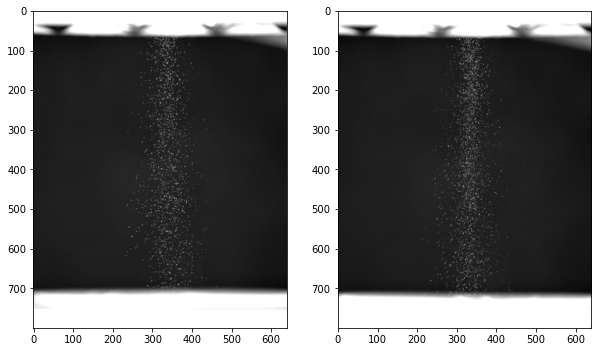

In [4]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(bench_mark[0][0], cmap = 'gray')
axs[1].imshow(ultrasound[0][0], cmap = 'gray')
plt.show()

## Set cropping and sampling

In [5]:
cropping = ((120,20),(0,0))

max_range = 1000
skip = 5
sampled_frame = np.arange(0, max_range, skip)

In [6]:
test_bench = pims.process.crop(bench_mark[0], cropping )
test_ultrasound = pims.process.crop(ultrasound[0], cropping )

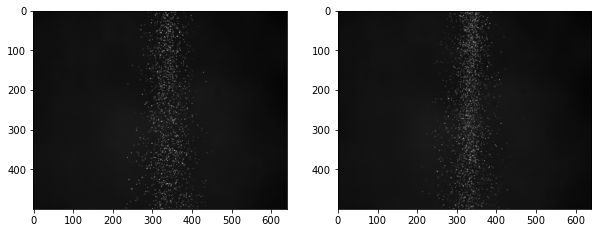

In [7]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(test_bench[0], cmap = 'gray')
axs[1].imshow(test_ultrasound[0], cmap = 'gray')
plt.show()

In [8]:
from skimage import restoration
from skimage import morphology

@pims.pipeline
def denoise_nl(image):
    sig = restoration.estimate_sigma(image,average_sigmas = True)
    return restoration.denoise_nl_means(image, sigma = sig)

@pims.pipeline
def denoise_median(image):
    selem = morphology.disk(3)
    return filters.median(image, selem)

In [9]:
@pims.pipeline
def binarise(image):
    thresh = filters.threshold_otsu(image)
    return (thresh <= image).astype(int)

@pims.pipeline
def binarise_half_way(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return ((min_val+(max_val-min_val)*0.25) <= image).astype(int)

binary_vid_bench = binarise_half_way(test_bench)
binary_vid_ultrasound = binarise_half_way(test_ultrasound)

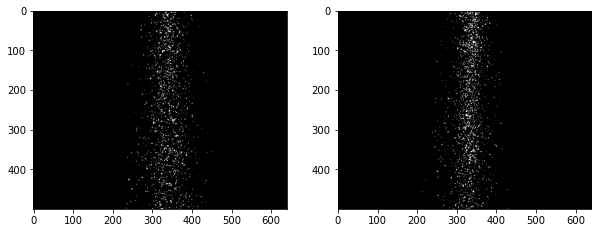

In [10]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(binary_vid_bench[0],cmap = 'gray')
axs[1].imshow(binary_vid_ultrasound[0],cmap = 'gray')
plt.show()

In [11]:
import time


start = time.process_time() 
h_t_bench = np.sum(binary_vid_bench[sampled_frame], axis = 0)
end = time.process_time() 

print('processing time: {}'.format(end-start))

processing time: 2.921875


In [12]:
start = time.process_time() 

h_t_ultrasound = np.sum(binary_vid_ultrasound[sampled_frame], axis = 0)

end = time.process_time() 

print('processing time: {}'.format(end-start))

processing time: 2.890625


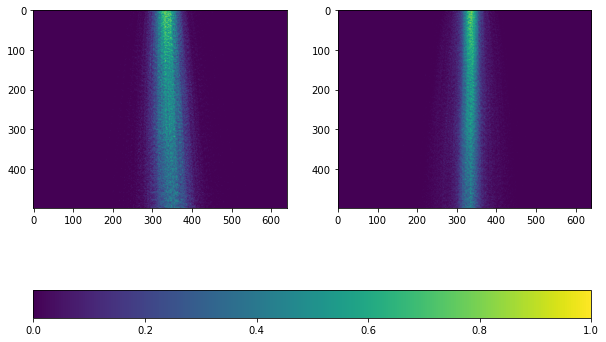

In [13]:
from matplotlib import colors

norm = colors.Normalize(vmin=0, vmax=1)

normed_h_t_bench = h_t_bench/np.max(h_t_bench)
normed_h_t_ultrasound = h_t_ultrasound/np.max(h_t_ultrasound)

fig, axs = plt.subplots( 1, 2, figsize = (10,10))
bench_im = axs[0].imshow(normed_h_t_bench)
ultrasound_im = axs[1].imshow(normed_h_t_ultrasound)

bench_im.set_norm(norm)
ultrasound_im.set_norm(norm)

fig.colorbar(bench_im, ax=axs, orientation='horizontal', fraction=.1)
plt.show()

In [14]:
bench_mark_data = np.zeros((len(bench_mark),h_t_bench.shape[0],h_t_bench.shape[1]))

for i, vid in enumerate(bench_mark):
    cropped_vid = pims.process.crop(vid, cropping)
    binary_vid = binarise_half_way(cropped_vid)
    bench_mark_data[i] = np.sum(binary_vid[sampled_frame], axis = 0)

In [15]:
ultrasound_data = np.zeros((len(ultrasound),h_t_ultrasound.shape[0],h_t_ultrasound.shape[1]))

for i, vid in enumerate(ultrasound):
    cropped_vid = pims.process.crop(vid, cropping)
    binary_vid = binarise_half_way(cropped_vid)
    ultrasound_data[i] = np.sum(binary_vid[sampled_frame], axis = 0)
    

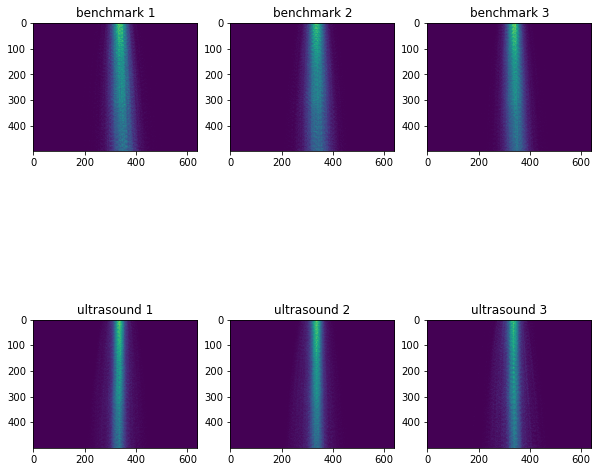

In [16]:
fig, axs = plt.subplots(2,3, figsize = (10,10))

for i in range(3):
    axs[0][i].set_title('benchmark {}'.format(i+1))
    axs[0][i].imshow(bench_mark_data[i])

for i in range(3):
    axs[1][i].set_title('ultrasound {}'.format(i+1))
    axs[1][i].imshow(ultrasound_data[i])
plt.show()
